In [26]:
import shapefile
from pyproj import Proj, transform
#from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point, Polygon
import sys
sys.path.append('../parsing')
import accessDB as db
%matplotlib inline

# data from https://city.milwaukee.gov/DownloadMapData3497.htm
# it is encoded in NAD27 in zone 4803 (Wisconsin South)

In [27]:
# open a single file
#f = open('ald2012.shp', 'rb')
#sf = shapefile.Reader(shp=f)

# load in maps
ald = shapefile.Reader('ald2016/alderman')
nbh = shapefile.Reader('hoods/neighborhood')
pol = shapefile.Reader('poldist/poldist')
ward = shapefile.Reader('wards/ward')
city = shapefile.Reader('corp/citylimit')

In [28]:
# converter for coordinates
inProj = Proj(init='EPSG:32054', preserve_units=True) # NAD27 Wisconsin South
outProj = Proj(proj='latlong', datum='WGS84', ellps='WGS84') # Latitude and Longitude

In [29]:
# read in a geolocated dataset

df = db.filter(nature='FIRE', doGeoLoc=True)
df.head()

C:\Users\Public\Documents\Anaconda3\lib\site-packages\pandas\core\frame.py:3137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


,Call Number,Date/Time,Location,Police District,Nature of Call,Status,Latitude,Longitude
ID,,,,,,,,
182551119-Assignment Completed,182551119,2018-09-12 11:55:20,"2050 S 24TH ST,MKE",2,FIRE,Assignment Completed,NaN,NaN
182551294-Assignment Completed,182551294,2018-09-12 13:00:41,"3127 W WISCONSIN AV,MKE",3,FIRE,Assignment Completed,NaN,NaN
182552544-Advised/Referral,182552544,2018-09-12 20:17:44,"815 S 28TH ST,MKE",2,FIRE,Advised/Referral,NaN,NaN
182552836-Service in Progress,182552836,2018-09-12 22:24:51,"2440 N 12TH ST,MKE",3,FIRE,Service in Progress,43.063,-87.9264
182552936-Service in Progress,182552936,2018-09-12 23:24:53,"815 W MEINECKE AV,MKE",3,FIRE,Service in Progress,43.0619,-87.9219


In [30]:
# parse the latitude and longitude of the coordinates column
#split = df['Coordinates'].str.split(',', 1, expand=True)
#df['lat'] = split[0].str.replace('{\'lat\': ', '').astype(float)
#df['long'] = split[1].str.replace('\'lng\': ', '')
#df['long'] = df['long'].str.replace('}', '').astype(float)
df = df.fillna('')

In [31]:
# create a new dataframe with just the coordinates
coords = df[['Latitude', 'Longitude']]
coords = coords.dropna()
# some empty are missed I guess
coords = coords[coords['Latitude'] != '']
coords = coords[coords['Longitude'] != '']
coords.head()

,Latitude,Longitude
ID,,
182552836-Service in Progress,43.063,-87.9264
182552936-Service in Progress,43.0619,-87.9219
182552936-Unable to Locate Complainant,43.0619,-87.9219
182552936-Assignment Completed,43.0619,-87.9219
182560157-Unable to Locate Complainant,43.081,-87.9686


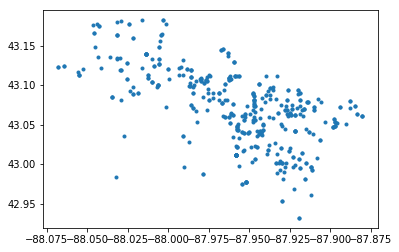

In [32]:
# just plot the points to confirms they're there
plt.plot(coords['Longitude'], coords['Latitude'], '.')

In [33]:
def plotOn(sf, coords, sfName, drawMap=False):
    # initialize plot size
    plt.figure(figsize=(10,18)) # approx dimensions of MKE is 5:9
    if not drawMap:
        # limit bounds of the plot
        plt.xlim(-88.1,-87.85)
        plt.ylim(42.9,43.2)
        m = plt
    else:
        # attempt to draw a map, it's not working
        m = Basemap(llcrnrlon=-88.1, llcrnrlat=42.9, urcrnrlon=-87.85, urcrnrlat=43.2, 
                    lon_0=(-88.1 + -87.85)/2, lat_0=(42.9 + 43.2)/2, 
                    resolution='i', projection='tmerc')
        m.drawcoastlines()
        m.drawrivers()
        m.drawmapboundary()
        m.fillcontinents(color='#ddaa66',lake_color='aqua')

    # loop through shapes
    polys = []
    for i,shape in enumerate(sf.shapes()):
        xs = []
        ys = []
        points = []

        # loop through points
        for point in shape.points:
            # parse points
            coord = [float('%.3f' % coord) for coord in point]
            # convert points
            x, y = transform(inProj, outProj, coord[0], coord[1])
            # add to list
            xs.append(x)
            ys.append(y)
            points.append((x, y))
            
        # make a polygon out of the points
        poly = Polygon(points)
        polys.append(poly)
        
        # find the district, ward, etc that a point is in
        for index, row in coords.iterrows():
            point = Point(row['Longitude'], row['Latitude'])
            if poly.contains(point):
                coords.loc[index, sfName] = i

        # plot shape
        m.plot(xs, ys, '-')

    #for index, row in coords.iterrows():
    m.plot(coords['Longitude'], coords['Latitude'], '.')
    plt.savefig('fire.png') #Save Figure needs to be before show to have it be made correctly
    plt.show()
    return polys

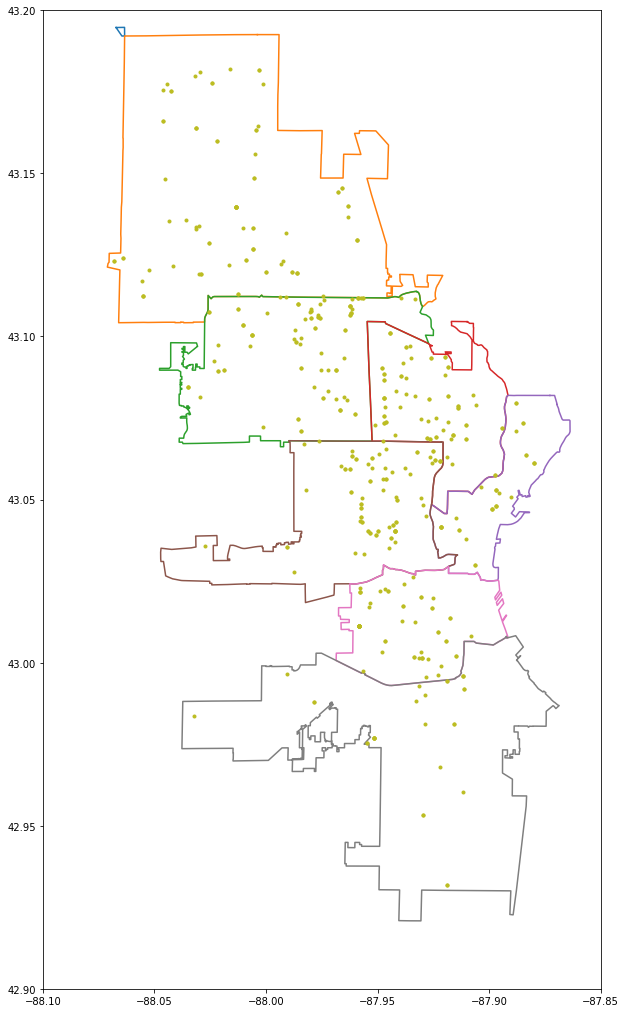

In [34]:
polys = plotOn(pol, coords, 'Police District')


In [35]:
coords.head()

,Latitude,Longitude,Police District
ID,,,
182552836-Service in Progress,43.063,-87.9264,5.0
182552936-Service in Progress,43.0619,-87.9219,5.0
182552936-Unable to Locate Complainant,43.0619,-87.9219,5.0
182552936-Assignment Completed,43.0619,-87.9219,5.0
182560157-Unable to Locate Complainant,43.081,-87.9686,2.0


In [36]:
print(coords)

                                       Latitude Longitude  Police District
ID                                                                        
182552836-Service in Progress            43.063  -87.9264              5.0
182552936-Service in Progress           43.0619  -87.9219              5.0
182552936-Unable to Locate Complainant  43.0619  -87.9219              5.0
182552936-Assignment Completed          43.0619  -87.9219              5.0
182560157-Unable to Locate Complainant   43.081  -87.9686              2.0
182560696-Assignment Completed          43.0508  -87.9418              5.0
182561951-Service in Progress           43.0332  -87.9561              5.0
182561963-Advised/Referral              43.0351   -87.945              5.0
182562503-Service in Progress           43.1334  -88.0101              1.0
182562554-Service in Progress           43.0497  -87.9412              5.0
182562554-Assignment Completed          43.0497  -87.9412              5.0
182562611-Assignment Comp

In [37]:
values_needed = coords['Police District'].value_counts()
values_needed['Type'] = 'FIRE'
values_needed.to_csv("counts.csv")
#Highest Counts of Battery occur in police districts 5